# 데이터 다운로드 및 전처리

In [1]:
import torch
import numpy as np
import scipy.signal
import requests
import os
import torch
from torchvision.io import read_image
import torch.nn as nn
import torchvision
from torchvision import transforms

# 이미지를 저장할 기본 경로 설정
image_path = './'

# 이미지를 파이토치 텐서로 변환하는 변환 함수 정의
transform = transforms.Compose([transforms.ToTensor()])

# MNIST 훈련 데이터셋 로드 (이미지 변환 적용, 자동 다운로드)
mnist_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=True,
                                           transform=transform,
                                           download=True)

from torch.utils.data import Subset

# 처음 10,000개 샘플을 검증 데이터셋으로 설정
mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000))

# 나머지 샘플을 훈련 데이터셋으로 설정
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))

# MNIST 테스트 데이터셋 로드 (이미지 변환 적용, 다운로드 없음)
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path,
                                                train=False,
                                                transform=transform,
                                                download=False)


from torch.utils.data import DataLoader

# 배치 크기 설정
batch_size = 64

# 재현 가능한 결과를 위한 랜덤 시드 설정
torch.manual_seed(1)

# 훈련 데이터셋을 위한 DataLoader 설정 (무작위 섞기 적용)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)

# 검증 데이터셋을 위한 DataLoader 설정 (무작위 섞기 미적용)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 46805052.54it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 118993805.33it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 49362907.27it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 25883870.61it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



# PyTorch로 CNN 구성하기

In [2]:
import torch
import torch.nn as nn
# 28x28 이미지 학습할 CNN 구성하기

# 순차적 모델 생성
model = nn.Sequential()

#------ 첫 번째 합성곱 계층 추가
# 1개의 입력 채널, 32개의 출력 채널(특징맵의 수), 커널 크기 5, 패딩 2
model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
# 첫 번째 ReLU 활성화 함수 추가
model.add_module('relu1', nn.ReLU())
# 첫 번째 풀링 계층 추가, 2x2 Max Pooling
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))

#------ 두 번째 합성곱 계층 추가
# 32개의 입력 채널(이전 계층의 출력), 64개의 출력 채널
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
#두 번째 ReLU 활성화 함수 추가
model.add_module('relu2', nn.ReLU())
# 두 번째 풀링 계층 추가
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))


#------ 세 번째 합성곱 계층 추가해보기


# 더미 데이터를 모델에 통과시켜 출력 크기 확인
x = torch.ones((4, 1, 28, 28))
print(model(x).shape)

# 출력확인
#----- Flatten 계층 추가
model.add_module('flatten', nn.Flatten())

# Flatten 계층 이후의 출력 크기 확인
x = torch.ones((4, 1, 28, 28))
print(model(x).shape)

torch.Size([4, 64, 7, 7])
torch.Size([4, 3136])


In [3]:
# 첫 번째 완전 연결(FC) 계층 추가
model.add_module('fc1', nn.Linear(3136, 1024))

# 세 번째 ReLU 활성화 함수 추가
model.add_module('relu4', nn.ReLU())

# 드랍아웃 계층 추가, 드랍아웃 확률 0.5
model.add_module('dropout', nn.Dropout(p=0.5))

# 두 번째 완전 연결 계층 추가
# 1024개의 입력 특성과 10개의 출력 노드(클래스)
model.add_module('fc2', nn.Linear(1024, 10))

# 디바이스 설정 (GPU 사용 가능 시 CUDA 사용, 그렇지 않으면 CPU 사용)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 모델을 해당 디바이스로 이동
model = model.to(device)


In [4]:
import torch
import torch.nn as nn

# 손실 함수와 최적화 함수 설정
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 모델 학습을 위한 함수 정의
def train(model, num_epochs, train_dl, valid_dl):
    # 훈련 및 검증에 대한 손실과 정확도를 기록할 리스트 초기화
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    # 지정된 에폭만큼 반복
    for epoch in range(num_epochs):
        # 모델을 훈련 모드로 설정
        model.train()

        # 훈련 데이터셋에 대한 반복
        for x_batch, y_batch in train_dl:
            # 데이터와 레이블을 GPU로 이동(사용 가능한 경우)
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # 모델을 통해 예측 수행
            pred = model(x_batch)

            # 손실 계산
            loss = loss_fn(pred, y_batch)

            # 역전파 수행
            loss.backward()

            # 최적화 단계
            optimizer.step()

            # 그래디언트 초기화
            optimizer.zero_grad()

            # 손실 및 정확도 업데이트
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        # 에폭별 평균 손실 및 정확도 계산
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        # 모델을 평가 모드로 설정
        model.eval()

        # 검증 데이터셋에 대한 반복
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        # 에폭별 평균 손실 및 정확도 계산
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        # 에폭별 훈련 및 검증 정확도 출력
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')

    # 손실 및 정확도 히스토리 반환
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

# 재현 가능한 결과를 위한 랜덤 시드 설정
torch.manual_seed(1)

# 에폭 수 설정
num_epochs = 10

# 학습 함수 호출 및 학습 진행
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9505 val_accuracy: 0.9813
Epoch 2 accuracy: 0.9840 val_accuracy: 0.9857
Epoch 3 accuracy: 0.9896 val_accuracy: 0.9831
Epoch 4 accuracy: 0.9918 val_accuracy: 0.9905
Epoch 5 accuracy: 0.9930 val_accuracy: 0.9897
Epoch 6 accuracy: 0.9948 val_accuracy: 0.9902
Epoch 7 accuracy: 0.9953 val_accuracy: 0.9901
Epoch 8 accuracy: 0.9963 val_accuracy: 0.9898
Epoch 9 accuracy: 0.9961 val_accuracy: 0.9900
Epoch 10 accuracy: 0.9970 val_accuracy: 0.9904


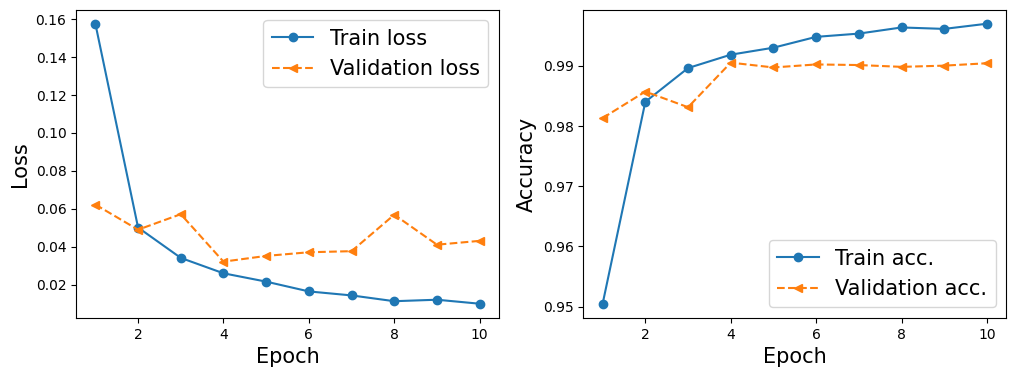

Test accuracy: 0.9925


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 학습 및 검증 기록을 hist 변수에서 추출
x_arr = np.arange(len(hist[0])) + 1

# 손실 및 정확도를 시각화하기 위한 그래프 설정
fig = plt.figure(figsize=(12, 4))

# 손실 그래프
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')  # 훈련 손실
ax.plot(x_arr, hist[1], '--<', label='Validation loss')  # 검증 손실
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)

# 정확도 그래프
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')  # 훈련 정확도
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')  # 검증 정확도
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

# 그래프 출력
plt.show()

# GPU 동기화 (GPU를 사용하는 경우 필요)
torch.cuda.synchronize()

# 모델을 CPU로 이동
model_cpu = model.cpu()

# 테스트 데이터셋에 모델 적용
pred = model_cpu(mnist_test_dataset.data.unsqueeze(1) / 255.)

# 정확도 계산
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}')


In [6]:
torch.cuda.synchronize()
model_cpu = model.cpu()
pred = model(mnist_test_dataset.data.unsqueeze(1) / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}')

Test accuracy: 0.9925


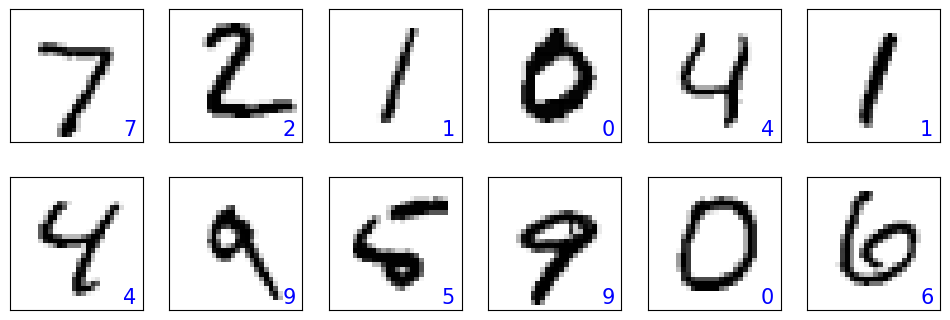

In [7]:
# 시각화
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = mnist_test_dataset[i][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1))
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(),
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)


#plt.savefig('figures/14_14.png')
plt.show()

In [8]:
import os

if not os.path.exists('models'):
    os.mkdir('models')

path = 'models/mnist-cnn.ph'
torch.save(model, path)


----

Readers may ignore the next cell.